TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0
Tests Passed
Tests Passed
Tests Passed
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'


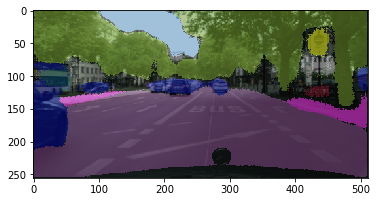

100%|█████████▉| 1199/1200 [03:02<00:00,  6.57it/s]


In [1]:
# %load main.py
import os
import os.path
import tensorflow as tf
import numpy as np
import helper
import helper_CityCape
import warnings
import matplotlib.pyplot as plt
import time
from distutils.version import LooseVersion
import scipy.misc
import project_tests as tests
import csv
from moviepy.editor import VideoFileClip
from functools import partial


with open('EL.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['Epoch', 'Mean Loss'])


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    tf.saved_model.loader.load(sess, [vgg_tag],vgg_path)
    
    graph= tf.get_default_graph()
    image_input= graph.get_tensor_by_name(vgg_input_tensor_name)
    keep= graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3= graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4= graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7= graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    
    
    
    return image_input, keep, layer3, layer4, layer7
tests.test_load_vgg(load_vgg, tf)


def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # TODO: Implement function
    conv_1x1_7= tf.layers.conv2d(vgg_layer7_out,num_classes,1,padding='same',
                                 kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    conv_1x1_4= tf.layers.conv2d(vgg_layer4_out,num_classes,1,padding='same',
                                 kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    conv_1x1_3= tf.layers.conv2d(vgg_layer3_out,num_classes,1,padding='same',
                                 kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    
    
    output= tf.layers.conv2d_transpose(conv_1x1_7,num_classes,4,(2,2),padding='same',
                                       kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                       kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    output= tf.add(output,conv_1x1_4)
    
    output= tf.layers.conv2d_transpose(output,num_classes,4,(2,2),padding='same',
                                       kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                       kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    
    outpu= tf.add(output, conv_1x1_3)
    output= tf.layers.conv2d_transpose(output,num_classes,16,(8,8),padding='same',
                                       kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                       kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    
    
    
    
    
    
    return output
tests.test_layers(layers)

def build_predictor(nn_last_layer):
    softmax_output = tf.nn.softmax(nn_last_layer)
    predictions_argmax = tf.argmax(softmax_output, axis=-1)
    return softmax_output, predictions_argmax


def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function
    
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    labels = tf.reshape(correct_label, (-1, num_classes))
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    optimizer= tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=0.9,beta2=0.999,epsilon=1e-08)
    train_op=optimizer.minimize(cross_entropy_loss)
    
    
    return logits, train_op, cross_entropy_loss
tests.test_optimize(optimize)


def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function
    print("Traning...")
    print()
    count=0
    mean_loss=0
    
    
    for epoch in range(epochs):
       
        for image, label in get_batches_fn(batch_size):
            _, loss= sess.run([train_op,cross_entropy_loss],
                              feed_dict={input_image:image,correct_label:label,keep_prob:.4, learning_rate:.0001})
            print("epoch: {}, loss: {}".format(epoch+1, loss))
            count+=1
            mean_loss+=loss
            
        mean_loss=mean_loss/count
        with open('EL.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow([epoch+1,mean_loss])
        
        mean_loss=0
        count=0
   
            
            
    pass
tests.test_train_nn(train_nn)


def prediction_image(image, sess,predictions_argmax, logits, keep_prob, input_image, image_shape,label_colors):
    
    image = scipy.misc.imresize(image, image_shape)
    t1=time.time()
    labels = sess.run([predictions_argmax], feed_dict={input_image: [image], keep_prob: 1})
    t2=time.time()
    print('time= ', t2-t1)
#     labels = sess.run(
#         [tf.nn.softmax(logits)],
#         {keep_prob: 1.0, input_image: [image]})
#     print(labels.shape)
    
    labels = labels[0].reshape(image_shape[0], image_shape[1])
#     labels = labels[0][:, 1].reshape(image_shape[0], image_shape[1])
    
#     segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
    labels_colored = np.zeros((image_shape[0], image_shape[1], 4))  # 4 for RGBA
    for label in label_colors:
        label_mask = labels == label
        labels_colored[label_mask] = np.array((*label_colors[label], 127))
#     mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    
    mask = scipy.misc.toimage(labels_colored, mode="RGBA")
#     plt.imshow(mask)
#     plt.show()
    street_im = scipy.misc.toimage(image)
    street_im.paste(mask, box=None, mask=mask)
    
    
    return np.array(street_im)


def process_image(image, sess,predictions_argmax, logits, keep_prob, input_image, image_shape,label_colors):
    
    image = scipy.misc.imresize(image, image_shape)
    t1=time.time()
    labels = sess.run([predictions_argmax], feed_dict={input_image: [image], keep_prob: 1})
    t2=time.time()
    print('time= ', t2-t1)
#     labels = sess.run(
#         [tf.nn.softmax(logits)],
#         {keep_prob: 1.0, input_image: [image]})
#     print(labels.shape)
    
    labels = labels[0].reshape(image_shape[0], image_shape[1])
#     labels = labels[0][:, 1].reshape(image_shape[0], image_shape[1])
    
#     segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
    labels_colored = np.zeros((image_shape[0], image_shape[1], 4))  # 4 for RGBA
    for label in label_colors:
        label_mask = labels == label
        labels_colored[label_mask] = np.array((*label_colors[label], 127))
#     mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    
    mask = scipy.misc.toimage(labels_colored, mode="RGBA")
#     plt.imshow(mask)
#     plt.show()
    street_im = scipy.misc.toimage(image)
    street_im.paste(mask, box=None, mask=mask)
    
    
    return np.array(street_im)


def run():
#     num_classes = 2
#     image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
#     tests.test_for_kitti_dataset(data_dir)

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)
    print('vgg downloaded')
    
    train_images, valid_images, test_images, num_classes, label_colors, image_shape = helper_CityCape.load_data(data_dir)
   

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/
    
    # Create function to get batches
    get_train_batches_fn = helper_CityCape.gen_batch_function(train_images, image_shape)
    get_valid_batches_fn = helper_CityCape.gen_batch_function(valid_images, image_shape)
    get_test_batches_fn = helper_CityCape.gen_batch_function(test_images, image_shape)


    # OPTIONAL: Augment Images for better results
    #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

    # TODO: Build NN using load_vgg, layers, and optimize function
    epochs=5
    batch_size=10
   
    label = tf.placeholder(tf.int32, shape=[None, None, None, num_classes])
    learning_rate = tf.placeholder(tf.float32)

    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        input_image, keep_prob, layer3_out, layer4_out, layer7_out= load_vgg(sess, vgg_path)
        layer_out=layers(layer3_out, layer4_out,layer7_out,num_classes)

        
        
        logits, train_op,loss=optimize(layer_out,label,learning_rate,num_classes)
        softmax_output, predictions_argmax = build_predictor(layer_out)

        # TODO: Train NN using the train_nn function
        
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        train_nn(sess,epochs,batch_size,get_train_batches_fn,train_op,loss,input_image,label,keep_prob,learning_rate)
        saver = tf.train.Saver()
#         output_node_names = 'Softmax'
#         output_graph_def = tf.graph_util.convert_variables_to_constants(
#             sess,  # The session is used to retrieve the weights
#             tf.get_default_graph().as_graph_def(),  # The graph_def is used to retrieve the nodes
#             output_node_names.split(",")  # The output node names are used to select the usefull nodes
#         )
        saver.save(sess, './runs/models/sem_seg_model.ckpt')
        # TODO: Save inference data using helper.save_inference_samples
        helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
        
        
        
        
#         tf.train.write_graph(tf.get_default_graph().as_graph_def(), '',  'runs/model/graph/base_graph.pb', False)
#         tf.train.write_graph(output_graph_def, '', 'runs/model/graph/frozen_graph.pb', False)
        
        #applying the model to video
        image_pred = scipy.misc.imread("./data/test.png")
        
        out_pred_image=prediction_image(image_pred,sess, predictions_argmax, logits, keep_prob,
                                        input_image, image_shape,label_colors)
        
        scipy.misc.imsave("predicted_image_city.png", out_pred_image)
        plt.imshow(out_pred_image)
        plt.show()
        video_input1='./data/project_video.mp4'
        video_output1='result1.mp4'
        
        video_input2='./data/challenge_video.mp4'
        video_output2='result2.mp4'
        
        video_input3='./data/harder_challenge_video.mp4'
        video_output3='result3.mp4'
        
        partial_process_image = partial(process_image,  sess=sess, predictions_argmax= predictions_argmax
                                        , logits=logits, keep_prob=keep_prob,
                                        input_image=input_image, image_shape=image_shape,label_colors=label_colors)
        clip1 = VideoFileClip(video_input1)
        video_clip = clip1.fl_image(partial_process_image) #NOTE: this function expects color images!!
        video_clip.write_videofile(video_output1, audio=False)
        
        clip2 = VideoFileClip(video_input2)
        video_clip = clip2.fl_image(partial_process_image) #NOTE: this function expects color images!!
        video_clip.write_videofile(video_output2, audio=False)
        
        clip3 = VideoFileClip(video_input3)
        video_clip = clip3.fl_image(partial_process_image) #NOTE: this function expects color images!!
        video_clip.write_videofile(video_output3, audio=False)
        
        
        
        
     
        


if __name__ == '__main__':
    print("start...")
    run()


In [ ]:
class TLClassifier(object):
    def __init__(self):
        #TODO load classifier

        self.graph=tf.Graph()

        with self.graph.as_default():
            od_graph_def= tf.GraphDef()
            with tf.gfile.GFile(ssd_inception_sim_model,'rb') as fid:
                serialized_graph= fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

            self.image_tensor=self.graph.get_tensor_by_name('image_tensor:0')
            self.detection_scores=self.graph.get_tensor_by_name('detection_scores:0')
            self.detection_classes=self.graph.get_tensor_by_name('detection_classes:0')

            self.sess= tf.Session(graph=self.graph)


    def get_classification(self, image):
        """Determines the color of the traffic light in the image
        Args:
            image (cv::Mat): image containing the traffic light
        Returns:
            int: ID of traffic light color (specified in styx_msgs/TrafficLight)
        """
        #TODO implement light color prediction
        class_threshold =.50

        with self.graph.as_default():
            image_np_expanded= np.expand_dims(image,axis=0)

            scores, classes = self.sess.run([self.detection_scores, self.detection_classes],
                                        feed_dict={self.image_tensor: image_np_expanded})
            scores=np.squeeze(scores)
            classes=np.squeeze(classes)
            classes=classes.astype(int)

            if scores[0] > class_threshold:
                if classes[0] == 1:
                    return TrafficLight.GREEN
                elif classes[0] == 2:
                    return TrafficLight.RED
                elif classes[0] == 3:
                    return TrafficLight.YELLOW
            else:
                return TrafficLight.UNKNOWN